In [1]:
from rich import print
from indra_db.client import get_curations
from collections import defaultdict
import pandas as pd
from collections import Counter
from tabulate import tabulate
from indra_cogex.client import Neo4jClient, autoclient
from IPython.display import HTML
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from indra_cogex.apps.curator.utils import iterate_conflicts
from indra_cogex.info import env
import pystow
from matplotlib_inline.backend_inline import set_matplotlib_formats

set_matplotlib_formats('svg')

In [2]:
env()

Key,Value
OS,posix
Platform,Darwin
Release,21.4.0
Time,Thu Apr 21 14:15:20 2022
Python,3.9.12
INDRA Version,1.21.0
INDRA Git Hash,fbdf9f50d128b5f22a38f3293ff8a2e3e36715a5
INDRA CoGEx Version,1.0.0
INDRA CoGEx Git Hash,8dcf15f5dc92d336ce0060cd88a3fac0d9e0b54f
INDRA CoGEx Branch,update-curation-cache


In [3]:
curations = get_curations()

In [4]:
source_counter = Counter(c['source'] for c in curations if c["source"])
source_df = pd.DataFrame(source_counter.most_common(), columns=["source", "count"])
source_df = source_df[source_df["count"] > 1]
source_df

,source,count
0,EMMAA,3310
1,DB REST API,2738
2,bioexp_paper_reach,1440
3,bioexp_paper_trips,1004
4,bioexp_biogrid,901
5,bioexp_paper_rlimsp,776
6,bioexp_refinements,659
7,bioexp_paper_sparser,625
8,bioexp_paper_medscan,416
9,CoGEx,365


In [5]:
dd: defaultdict[int, defaultdict[bool, dict[int, any]]] = defaultdict(lambda: defaultdict(dict))
for curation in curations:
    positive = curation["tag"] == "correct"
    dd[curation["pa_hash"]][positive][curation["id"]] = curation
dd = {k: dict(v) for k,v in dd.items()}

In [6]:
df = pd.DataFrame(
    [
        (
            k, 
            len(v.get(True, [])),
            len(v.get(False, [])),
        )
        for k, v in dd.items()
    ],
    columns=["stmt_hash", "correct", "incorrect"],
)
df

,stmt_hash,correct,incorrect
0,-3.133747e+16,0,1
1,1.061511e+16,0,1
2,-2.840638e+16,0,1
3,3.314674e+16,1,0
4,-1.312914e+16,0,2
...,...,...,...
6235,3.087685e+16,0,1
6236,2.649926e+16,0,3
6237,1.705045e+16,3,0
6238,2.425224e+16,2,0


In [7]:
remapping = {
    "patrick.anton.greene@gmail.com": "patrick_greene@hms.harvard.edu",
    "sambunga094@gmail.com": "samuel_bunga@hms.harvard.edu",
    "sambunga094@gmail.com@gmail.com": "samuel_bunga@hms.harvard.edu",
}
skip = {
    "minghanwu155@gmail.com", "tester"
}
renames = {
    "cthoyt": "Charlie Hoyt",
    "rphair": "Robert Phair",
    "depratt": "Dexter Pratt",
    "bachmanjohn": "John Bachman",
    "cgaray": "Christopher Garay",
    "vanauken": "Kim Van Auken",
}
curators = Counter(
    remapping.get(c["curator"], c["curator"]) 
    for c in curations 
    if c["curator"] not in skip
)

def _clean_email(s):
    s = s.split("@")[0]
    s = renames.get(s, s)
    return s.replace("_", " ").replace(".", " ").title()

count_df = pd.DataFrame(curators.most_common(), columns=["curator_email", "count"])
count_df["curator"] = count_df["curator_email"].map(_clean_email)
# count_df

In [8]:
positive = sorted((c["date"], c["tag"]) for c in curations if c["tag"] == "correct")
negative = sorted((c["date"], c["tag"]) for c in curations if c["tag"] != "correct")


time_df = pd.DataFrame(
    [
        *(("correct", tag, date, i) for i, (date, tag) in enumerate(positive)), 
        *(("incorrect", tag, date, i) for i, (date, tag) in enumerate(negative)),
    ],
    columns=["status", "tag", "date", "count"],
)
time_df

,status,tag,date,count
0,correct,correct,2018-11-14 05:49:04.832777,0
1,correct,correct,2018-11-14 07:48:43.475813,1
2,correct,correct,2018-11-14 07:49:13.238925,2
3,correct,correct,2018-11-14 07:49:37.893241,3
4,correct,correct,2018-11-14 07:56:41.955224,4
...,...,...,...,...
13266,incorrect,grounding,2022-04-21 11:18:42.264122,7318
13267,incorrect,wrong_relation,2022-04-21 11:24:28.048130,7319
13268,incorrect,grounding,2022-04-21 11:31:58.503511,7320
13269,incorrect,no_relation,2022-04-21 11:32:41.728122,7321


In [9]:
error_type_df = time_df.groupby("tag").count()["date"].sort_values(ascending=False).to_frame().reset_index()
error_type_df.columns = ["tag", "count"]
error_type_df["tag"] = error_type_df["tag"].map(lambda s: s.replace("_", " ").title())
error_type_df = error_type_df[error_type_df["count"] > 1]
error_type_df

,tag,count
0,Correct,5948
1,Grounding,1871
2,No Relation,1742
3,Wrong Relation,912
4,Entity Boundaries,871
5,Polarity,677
6,Act Vs Amt,422
7,Other,278
8,Negative Result,247
9,Hypothesis,198


In [10]:
status_counter = Counter(
    status
    for _stmt_hash, _evidence_count, status in iterate_conflicts(curations=curations)                  
)

INFO: [2022-04-21 14:15:27] indra_cogex.client.neo4j_client - Using configured URL for INDRA neo4j connection
INFO: [2022-04-21 14:15:27] indra_cogex.client.neo4j_client - Using configured credentials for INDRA neo4j connection


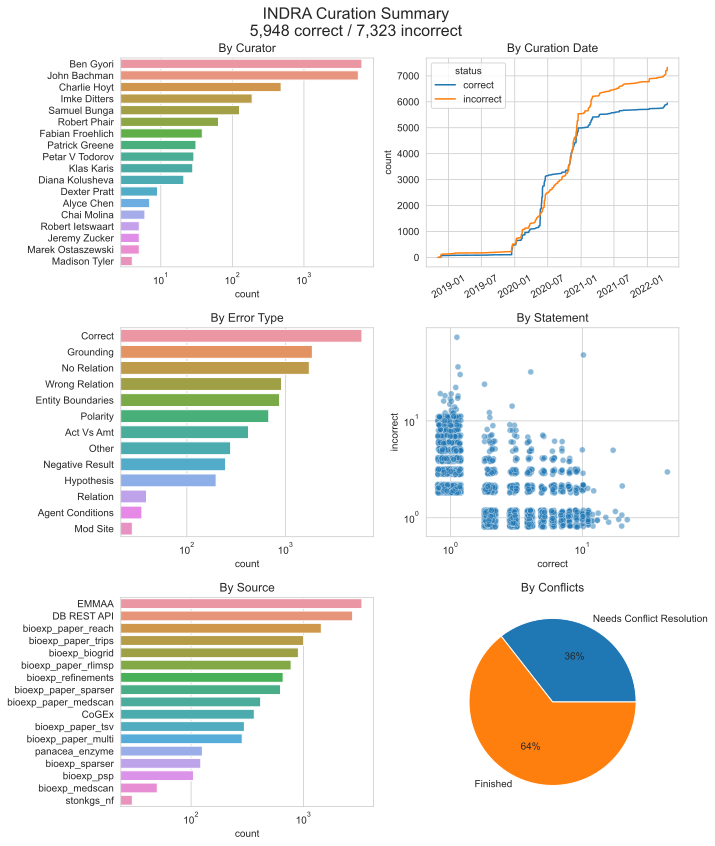

In [11]:
sns.set_style("whitegrid")

fig, ((lax, rax), (blax, brax), (bblax, bbrax)) = plt.subplots(nrows=3, ncols=2, figsize=(10, 4 * 3))

sns.barplot(data=count_df[count_df["count"] > 2], y="curator", x="count", ax=lax)
lax.set_xscale("log")
lax.set_ylabel("")
lax.set_title("By Curator")


sns.lineplot(data=time_df, x="date", y="count", hue="status", ax=rax)
rax.set_title("By Curation Date")
rax.set_xlabel("")
rax.tick_params(axis='x', rotation=30)

sns.barplot(data=error_type_df, x="count", y="tag", ax=blax)
blax.set_ylabel("")
blax.set_title("By Error Type")
blax.set_xscale("log")

sns.scatterplot(
    data=df, 
    x=1 + df["correct"] + np.random.uniform(-0.2, 0.2, size=df["correct"].size), 
    y=1 + df["incorrect"] + np.random.uniform(-0.2, 0.2, size=df["incorrect"].size), 
    alpha=0.5,
    ax=brax,
)
brax.set_xscale("log")
brax.set_yscale("log")
brax.set_title("By Statement")

sns.barplot(data=source_df[source_df["count"] > 10], y="source", x="count", ax=bblax)
bblax.set_xscale("log")
bblax.set_ylabel("")
bblax.set_title("By Source")

bbrax.pie(
    (status_counter[True], status_counter[False]), 
    labels=("Needs Conflict Resolution", "Finished"),
    autopct='%.0f%%',
)
bbrax.set_title("By Conflicts")

total_correct = df.correct.sum()
total_incorrect = df.incorrect.sum()
plt.suptitle(f"INDRA Curation Summary\n{total_correct:,} correct / {total_incorrect:,} incorrect", size=16)

plt.tight_layout()
path = pystow.join("indra", "curation", name="curation_summary.png")
plt.savefig(path, dpi=300)
plt.show()